# Imports and model loading

In [35]:
import pathlib
import pickle
import torch
import torch.optim as optim

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from src.data_loaders import Importer
from src.training_utils import train_model
from src.cam_utils import generate_CAMs, CAMs_plot_gen_final, viz_final
from src.utils import test_model, get_preds_from_model
from src.architecture import CNN_SSH

from sklearn.decomposition import PCA
from umap import UMAP

# To avoid a numba deprecation warning, we initialize UMAP here
tmp_umap = UMAP(n_neighbors=30, min_dist=0.0, n_components=2, metric='euclidean')
umap_tmp = tmp_umap.fit_transform(np.random.rand(100, 2500))
del tmp_umap

%reload_ext autoreload
%autoreload 2
%aimport src.training_utils
%aimport src.cam_utils
%aimport src.utils

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [36]:
plots_save_path = pathlib.Path("./00_demonstrations_data/figures/")
png_save_path = plots_save_path.joinpath("PNG/")
models_root = pathlib.Path("./00_demonstrations_data/models/")

plots_save_path.mkdir(exist_ok=True, parents=True)
png_save_path.mkdir(exist_ok=True, parents=True)
models_root.mkdir(exist_ok=True, parents=True)

Here we load the model for the CAM analysis. The options are:
* 1. The model we trained in [the previous notebook](./02_architecture_training.ipynb) notebook, or one of the models highlighted in the paper:
* 2. [well_generalizing_good_CAM](./00_demonstrations_data/models/well_generalizing_good_CAM/)
* 3. [well_generalizing_misleading_CAM](./00_demonstrations_data/models/well_generalizing_misleading_CAM/)
* 4. [poorly_generalizing_good_CAM](./00_demonstrations_data/models/poorly_generalizing_good_CAM/)
* 5. [poorly_generalizing_misleading_CAM](./00_demonstrations_data/models/poorly_generalizing_misleading_CAM/)

In [3]:
available_models = {
    0: models_root.joinpath('training_demonstration'),
    1: models_root.joinpath('well_generalizing_good_CAM'),
    2: models_root.joinpath('well_generalizing_misleading_CAM'),
    3: models_root.joinpath('poorly_generalizing_good_CAM'),
    4: models_root.joinpath('poorly_generalizing_misleading_CAM'),
}

In [4]:
model_to_load = available_models[0]

folder_pca = model_to_load.joinpath("PCA")
folder_pca.mkdir(parents=True, exist_ok=True)

In [5]:
load_path = pathlib.Path("./00_demonstrations_data/datasets")

disorderless_ds_path = load_path.joinpath("disorderless")
disordered_001_ds_path = load_path.joinpath("disordered_W=0.01")
disordered_005_ds_path = load_path.joinpath("disordered_W=0.05")
disordered_015_ds_path = load_path.joinpath("disordered_W=0.15")
disordered_050_ds_path = load_path.joinpath("disordered_W=0.5")
disordered_100_ds_path = load_path.joinpath("disordered_W=1.0")
disordered_200_ds_path = load_path.joinpath("disordered_W=2.0")

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else
                        'mps' if torch.backends.mps.is_available() else
                        "cpu")

In [7]:
class_names = ["Trivial", "Topological"]

In [8]:
model = CNN_SSH().float().to(device)
model.load_state_dict(torch.load(model_to_load.joinpath("trained_model.dict"), map_location=device))
model.float().to(device)
model.eval()

CNN_SSH(
  (cnn_layers_1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01, inplace=True)
    (7): Dropout(p=0.5, inplace=False)
  )
  (cnn_layers_2): Sequential(
    (0): Conv2d(7, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (avg_pool): Sequential(
    (0): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (linear_layers): Sequential(
    (0): Linear(i

If you wish to calculate the clustering for a model trained without small disorder added to a training set, remove contents of `perturb_list`

In [9]:
perturb_list = [disordered_001_ds_path, disordered_005_ds_path]
perturb = len(perturb_list) > 0
used_ds_names = [disorderless_ds_path] + perturb_list
used_ds_names = [str(x) for x in used_ds_names]

# Principal Component Analysis

Generation of CAMs. The helper functions are defined in [cam_utils.py](./src/cam_utils.py) helper file.

Hyperparameters for import and PCA

In [10]:
clustering_batch_size = -1
n_comp = 2

Now let's define for which disorders do we want to analyze clustering...

In [11]:
test_paths = [
    disorderless_ds_path,
    disordered_015_ds_path,
    disordered_050_ds_path,
    disordered_100_ds_path,
    disordered_200_ds_path
    ]

w_tab = ["0", "0.15", "0.5", "1.0", "2.0", "3.0"]

...and for which named layers of the network (see [this notebook](./02_architecture_training.ipynb) for details on the architecture).

In [12]:
layer_names = [
    'clear', 
    'conv2d1', 
    # 'conv2d2', 
    'cnn_seq_1', 
    # 'conv2d3', 
    'cnn_seq_2', 
    'avg_pool', 
    ]


We want to asess clustering of:  
(a) Training and validation datasets (including the slightly disordered data)   
(b) Test datasets vor various disorders

Let's walk through clustering analysis of a the disorderless datasets.   
An automated approach for all datasets, including the clustering of a dataset with small disorder is in [clustering_utils.py](./src/clustering_utils.py) helper file.   
If you wish to calculate the clustering for full dataset, without excluding the transition region, set the `exclude_transition` variable to `True`

In [13]:
test_path = test_paths[0]
exclude_transition = False

Data loading

In [14]:
ds = Importer(test_path, clustering_batch_size)
test_loader = ds.get_test_loader()

W = ds.W_tab[0]
if W == 0:
    W = f"{W:.0f}"
elif 0 < W < 0.5 :
    W = f"{W:.2f}"
else:
    W = f"{W:.1f}"

p = folder_pca.joinpath(f"W={W}")
p.mkdir(parents=True, exist_ok=True)

In [15]:
ds_000 = Importer(disorderless_ds_path, clustering_batch_size)
ds_001 = Importer(disordered_001_ds_path, clustering_batch_size)
ds_005 = Importer(disordered_005_ds_path, clustering_batch_size)

test_loader_000 = ds_000.get_test_loader()
test_loader_001 = ds_001.get_test_loader()
test_loader_005 = ds_005.get_test_loader()

val_loader_000 = ds_000.get_val_loader()
val_loader_001 = ds_001.get_val_loader()
val_loader_005 = ds_005.get_val_loader()

tr_loader_000 = ds_000.get_train_loader()
tr_loader_001 = ds_001.get_train_loader()
tr_loader_005 = ds_005.get_train_loader()

To gather the activations in the network, we will utilize a `register_forward_hook` feature, which allows for gathering the representations created during a forward pass.

In [16]:
activation = {}
activation_trn = {}
activation_val = {}
def getActivation(name, dset_name='test'):
    # the hook signature
    if dset_name == 'test':
        def hook(model, input, output):
            activation[name] = output.detach().cpu().numpy()
    elif dset_name == 'trn':
        def hook(model, input, output):
            activation_trn[name] = output.detach().cpu().numpy()
    elif dset_name == 'val':
        def hook(model, input, output):
            activation_val[name] = output.detach().cpu().numpy()
    return hook

conv2d1_list, conv2d2_list, cnn_seq_1_list, conv2d3_list, cnn_seq_2_list, avgpool_list = [], [], [], [], [], []
conv2d1_list_val, conv2d2_list_val, cnn_seq_1_list_val, conv2d3_list_val, cnn_seq_2_list_val, avgpool_list_val = [], [], [], [], [], []
conv2d1_list_trn, conv2d2_list_trn, cnn_seq_1_list_trn, conv2d3_list_trn, cnn_seq_2_list_trn, avgpool_list_trn = [], [], [], [], [], []

t_l = test_loader
trn_l = tr_loader_000
val_l = val_loader_000

Now we need to make a forward pass through the networks to populate the arrays prepared for activations gathering

Test data

In [17]:
hook_conv2d1 = model.cnn_layers_1[0].register_forward_hook(getActivation('cnn_layers_1_condv2d1'))
hook_conv2d2 = model.cnn_layers_1[4].register_forward_hook(getActivation('cnn_layers_1_condv2d2'))
hook_cnn_seq_1 = model.cnn_layers_1.register_forward_hook(getActivation('cnn_layers_1'))
hook_conv2d3 = model.cnn_layers_2[0].register_forward_hook(getActivation('cnn_layers_2_condv2d1'))
hook_cnn_seq_2 = model.cnn_layers_2.register_forward_hook(getActivation('cnn_layers_2'))
hook_avgpool = model.avg_pool[0].register_forward_hook(getActivation('avg_pool'))

hooks_list = [hook_conv2d1, hook_conv2d2, hook_cnn_seq_1, hook_conv2d3, hook_cnn_seq_2, hook_avgpool]

for X, y in t_l:
    ds_len = y.shape[0]

    if exclude_transition:
        X_subset = torch.concatenate([X[:(ds_len//2 - ds_len//10)], X[(ds_len//2 + ds_len//10):]], axis=0)
        y_subset = torch.concatenate([y[:(ds_len//2 - ds_len//10)], y[(ds_len//2 + ds_len//10):]], axis=0)
    else:
        X_subset = X
        y_subset = y

    X_subset = X_subset.to(device)
    y_subset = y_subset.to(device)
    out = model(X_subset)

    conv2d1_list.append(activation['cnn_layers_1_condv2d1'])
    conv2d2_list.append(activation['cnn_layers_1_condv2d2'])
    cnn_seq_1_list.append(activation['cnn_layers_1'])
    conv2d3_list.append(activation['cnn_layers_2_condv2d1'])
    cnn_seq_2_list.append(activation['cnn_layers_2'])
    avgpool_list.append(activation['avg_pool'])

for hook in hooks_list:
    hook.remove()

Validation data

In [18]:
val_hook_conv2d1 = model.cnn_layers_1[0].register_forward_hook(getActivation('cnn_layers_1_condv2d1', 'val'))
val_hook_conv2d2 = model.cnn_layers_1[4].register_forward_hook(getActivation('cnn_layers_1_condv2d2', 'val'))
val_hook_cnn_seq_1 = model.cnn_layers_1.register_forward_hook(getActivation('cnn_layers_1', 'val'))
val_hook_conv2d3 = model.cnn_layers_2[0].register_forward_hook(getActivation('cnn_layers_2_condv2d1', 'val' ))
val_hook_cnn_seq_2 = model.cnn_layers_2.register_forward_hook(getActivation('cnn_layers_2', 'val'))
val_hook_avgpool = model.avg_pool[0].register_forward_hook(getActivation('avg_pool', 'val'))

val_hooks_list = [val_hook_conv2d1, val_hook_conv2d2, val_hook_cnn_seq_1, val_hook_conv2d3, val_hook_cnn_seq_2, val_hook_avgpool]

for X, y in val_l:
    ds_len = y.shape[0]

    if exclude_transition:
        X_subset_val = torch.concatenate([X[:(ds_len//2 - ds_len//10)], X[(ds_len//2 + ds_len//10):]], axis=0)
        y_subset_val = torch.concatenate([y[:(ds_len//2 - ds_len//10)], y[(ds_len//2 + ds_len//10):]], axis=0)
    else:
        X_subset_val = X
        y_subset_val = y

    X_subset_val = X_subset_val.to(device)
    y_subset_val = y_subset_val.to(device)
    out_val = model(X_subset_val)

    conv2d1_list_val.append(activation_val['cnn_layers_1_condv2d1'])
    conv2d2_list_val.append(activation_val['cnn_layers_1_condv2d2'])
    cnn_seq_1_list_val.append(activation_val['cnn_layers_1'])
    conv2d3_list_val.append(activation_val['cnn_layers_2_condv2d1'])
    cnn_seq_2_list_val.append(activation_val['cnn_layers_2'])
    avgpool_list_val.append(activation_val['avg_pool'])

for hook in val_hooks_list:
    hook.remove()

Training data

In [19]:
trn_hook_conv2d1 = model.cnn_layers_1[0].register_forward_hook(getActivation('cnn_layers_1_condv2d1', 'trn'))
trn_hook_conv2d2 = model.cnn_layers_1[4].register_forward_hook(getActivation('cnn_layers_1_condv2d2', 'trn'))
trn_hook_cnn_seq_1 = model.cnn_layers_1.register_forward_hook(getActivation('cnn_layers_1', 'trn'))
trn_hook_conv2d3 = model.cnn_layers_2[0].register_forward_hook(getActivation('cnn_layers_2_condv2d1', 'trn' ))
trn_hook_cnn_seq_2 = model.cnn_layers_2.register_forward_hook(getActivation('cnn_layers_2', 'trn'))
trn_hook_avgpool = model.avg_pool[0].register_forward_hook(getActivation('avg_pool', 'trn'))

trn_hooks_list = [trn_hook_conv2d1, trn_hook_conv2d2, trn_hook_cnn_seq_1, trn_hook_conv2d3, trn_hook_cnn_seq_2, trn_hook_avgpool]

for X, y in trn_l:
    ds_len = y.shape[0]

    if exclude_transition:
        X_subset_trn = torch.concatenate([X[:(ds_len//2 - ds_len//10)], X[(ds_len//2 + ds_len//10):]], axis=0)
        y_subset_trn = torch.concatenate([y[:(ds_len//2 - ds_len//10)], y[(ds_len//2 + ds_len//10):]], axis=0)
    else:
        X_subset_trn = X
        y_subset_trn = y

    X_subset_trn = X_subset_trn.to(device)
    y_subset_trn = y_subset_trn.to(device)
    out_trn = model(X_subset_trn)

    conv2d1_list_trn.append(activation_trn['cnn_layers_1_condv2d1'])
    conv2d2_list_trn.append(activation_trn['cnn_layers_1_condv2d2'])
    cnn_seq_1_list_trn.append(activation_trn['cnn_layers_1'])
    conv2d3_list_trn.append(activation_trn['cnn_layers_2_condv2d1'])
    cnn_seq_2_list_trn.append(activation_trn['cnn_layers_2'])
    avgpool_list_trn.append(activation_trn['avg_pool'])

for hook in trn_hooks_list:
    hook.remove()

Preprocessing before clustering

In [20]:
# Join along the first axis
conv2d1 = np.concatenate(np.array(conv2d1_list), axis=0)
conv2d2 = np.concatenate(np.array(conv2d2_list), axis=0)
conv2d3 = np.concatenate(np.array(conv2d3_list), axis=0)
cnn_seq_1 = np.concatenate(np.array(cnn_seq_1_list), axis=0)
cnn_seq_2 = np.concatenate(np.array(cnn_seq_2_list), axis=0)
avg_pool = np.concatenate(np.array(avgpool_list), axis=0)

color_names = ['Trivial', 'Topological']
classes = [color_names[i] for i in y_subset.detach().cpu().numpy()]
preds = [color_names[i] for i in out.argmax(axis=1).detach().cpu().numpy()]


# Val data

val_conv2d1 = np.concatenate(np.array(conv2d1_list_val), axis=0)
val_conv2d2 = np.concatenate(np.array(conv2d2_list_val), axis=0)
val_conv2d3 = np.concatenate(np.array(conv2d3_list_val), axis=0)
val_cnn_seq_1 = np.concatenate(np.array(cnn_seq_1_list_val), axis=0)
val_cnn_seq_2 = np.concatenate(np.array(cnn_seq_2_list_val), axis=0)
val_avg_pool = np.concatenate(np.array(avgpool_list_val), axis=0)

val_color_names = ['Val_Trivial', 'Val_Topological']
val_classes = [val_color_names[i] for i in y_subset_val.detach().cpu().numpy()]
val_preds = [val_color_names[i] for i in out_val.argmax(axis=1).detach().cpu().numpy()]

# Trn data

trn_conv2d1 = np.concatenate(np.array(conv2d1_list_trn), axis=0)
trn_conv2d2 = np.concatenate(np.array(conv2d2_list_trn), axis=0)
trn_conv2d3 = np.concatenate(np.array(conv2d3_list_trn), axis=0)
trn_cnn_seq_1 = np.concatenate(np.array(cnn_seq_1_list_trn), axis=0)
trn_cnn_seq_2 = np.concatenate(np.array(cnn_seq_2_list_trn), axis=0)
trn_avg_pool = np.concatenate(np.array(avgpool_list_trn), axis=0)

trn_color_names = ['Trn_Trivial', 'Trn_Topological']
trn_classes = [trn_color_names[i] for i in y_subset_trn.detach().cpu().numpy()]
trn_preds = [trn_color_names[i] for i in out_trn.argmax(axis=1).detach().cpu().numpy()]

PCA - Raw data

In [21]:
pca_clear = PCA(n_components=n_comp)

ds_clear = pca_clear.fit_transform(X_subset.reshape(len(classes), -1).detach().cpu().numpy())


if n_comp == 2:
    df = pd.DataFrame(ds_clear, columns=['x', 'y'])
else:
    df = pd.DataFrame(ds_clear, columns=['x', 'y', 'z'])
df['class'] = classes
df["pred"] = preds

val_ds = pca_clear.transform(X_subset_val.reshape(len(val_classes), -1).detach().cpu().numpy())
trn_ds = pca_clear.transform(X_subset_trn.reshape(len(trn_classes), -1).detach().cpu().numpy())

df_val = pd.DataFrame(val_ds, columns=['val_x', 'val_y'])

df_val["val_class"] = val_classes
df_val["val_pred"] = val_preds

df_trn = pd.DataFrame(trn_ds, columns=['trn_x', 'trn_y'])

df_trn["trn_class"] = trn_classes
df_trn["trn_pred"] = trn_preds

df = pd.concat([df, df_val, df_trn], axis=1)

df.to_csv(p.joinpath(f"clear_PCA_W={W}.csv"), index=False)

PCA - Conv 1

In [22]:
pca_conv2d1 = PCA(n_components=n_comp)

ds_conv2d1 = pca_conv2d1.fit_transform(conv2d1.reshape(len(classes), -1))


if n_comp == 2:
    df = pd.DataFrame(ds_conv2d1, columns=['x', 'y'])
else:
    df = pd.DataFrame(ds_conv2d1, columns=['x', 'y', 'z'])
df['class'] = classes
df["pred"] = preds

val_ds = pca_conv2d1.transform(val_conv2d1.reshape(len(val_classes), -1))
trn_ds = pca_conv2d1.transform(trn_conv2d1.reshape(len(trn_classes), -1))

df_val = pd.DataFrame(val_ds, columns=['val_x', 'val_y'])

df_val["val_class"] = val_classes
df_val["val_pred"] = val_preds

df_trn = pd.DataFrame(trn_ds, columns=['trn_x', 'trn_y'])

df_trn["trn_class"] = trn_classes
df_trn["trn_pred"] = trn_preds

df = pd.concat([df, df_val, df_trn], axis=1)

df.to_csv(p.joinpath(f"conv2d1_PCA_W={W}.csv"), index=False)

PCA - Conv 2

In [23]:
pca_conv2d2 = PCA(n_components=n_comp)

ds_conv2d2 = pca_conv2d2.fit_transform(conv2d2.reshape(len(classes), -1))

if n_comp == 2:
    df = pd.DataFrame(ds_conv2d2, columns=['x', 'y'])
else:
    df = pd.DataFrame(ds_conv2d2, columns=['x', 'y', 'z'])
df['class'] = classes
df["pred"] = preds

val_ds = pca_conv2d2.transform(val_conv2d2.reshape(len(val_classes), -1))
trn_ds = pca_conv2d2.transform(trn_conv2d2.reshape(len(trn_classes), -1))

df_val = pd.DataFrame(val_ds, columns=['val_x', 'val_y'])

df_val["val_class"] = val_classes
df_val["val_pred"] = val_preds

df_trn = pd.DataFrame(trn_ds, columns=['trn_x', 'trn_y'])

df_trn["trn_class"] = trn_classes
df_trn["trn_pred"] = trn_preds

df = pd.concat([df, df_val, df_trn], axis=1)

df.to_csv(p.joinpath(f"conv2d2_PCA_W={W}.csv"), index=False)

PCA - ReLU(Conv 2)

In [24]:
pca_seq_1 = PCA(n_components=n_comp)

ds_seq_1 = pca_seq_1.fit_transform(cnn_seq_1.reshape(len(classes), -1))

if n_comp == 2:
    df = pd.DataFrame(ds_seq_1, columns=['x', 'y'])
else:
    df = pd.DataFrame(ds_seq_1, columns=['x', 'y', 'z'])
df['class'] = classes
df["pred"] = preds

val_ds = pca_seq_1.transform(val_cnn_seq_1.reshape(len(val_classes), -1))
trn_ds = pca_seq_1.transform(trn_cnn_seq_1.reshape(len(trn_classes), -1))

df_val = pd.DataFrame(val_ds, columns=['val_x', 'val_y'])

df_val["val_class"] = val_classes
df_val["val_pred"] = val_preds

df_trn = pd.DataFrame(trn_ds, columns=['trn_x', 'trn_y'])

df_trn["trn_class"] = trn_classes
df_trn["trn_pred"] = trn_preds

df = pd.concat([df, df_val, df_trn], axis=1)

df.to_csv(p.joinpath(f"cnn_seq_1_PCA_W={W}.csv"), index=False)


PCA - Conv 3

In [25]:
pca_conv2d3 = PCA(n_components=n_comp)

ds_conv2d3 = pca_conv2d3.fit_transform(conv2d3.reshape(len(classes), -1))

if n_comp == 2:
    df = pd.DataFrame(ds_conv2d3, columns=['x', 'y'])
else:
    df = pd.DataFrame(ds_conv2d3, columns=["x", "y", "z"])
df["class"] = classes
df["pred"] = preds

val_ds = pca_conv2d3.transform(val_conv2d3.reshape(len(val_classes), -1))
trn_ds = pca_conv2d3.transform(trn_conv2d3.reshape(len(trn_classes), -1))

df_val = pd.DataFrame(val_ds, columns=['val_x', 'val_y'])

df_val["val_class"] = val_classes
df_val["val_pred"] = val_preds

df_trn = pd.DataFrame(trn_ds, columns=['trn_x', 'trn_y'])

df_trn["trn_class"] = trn_classes
df_trn["trn_pred"] = trn_preds

df = pd.concat([df, df_val, df_trn], axis=1)

df.to_csv(p.joinpath(f"conv2d3_PCA_W={W}.csv"), index=False)


PCA - ReLU(Conv 3)

In [26]:
pca_seq_2 = PCA(n_components=n_comp)

ds_seq_2 = pca_seq_2.fit_transform(cnn_seq_2.reshape(len(classes), -1))

if n_comp == 2:
    df = pd.DataFrame(ds_seq_2, columns=['x', 'y'])
else:
    df = pd.DataFrame(ds_seq_2, columns=["x", "y", "z"])
df["class"] = classes
df["pred"] = preds

val_ds = pca_seq_2.transform(val_cnn_seq_2.reshape(len(val_classes), -1))
trn_ds = pca_seq_2.transform(trn_cnn_seq_2.reshape(len(trn_classes), -1))

df_val = pd.DataFrame(val_ds, columns=['val_x', 'val_y'])

df_val["val_class"] = val_classes
df_val["val_pred"] = val_preds

df_trn = pd.DataFrame(trn_ds, columns=['trn_x', 'trn_y'])

df_trn["trn_class"] = trn_classes
df_trn["trn_pred"] = trn_preds

df = pd.concat([df, df_val, df_trn], axis=1)


df.to_csv(p.joinpath(f"cnn_seq_2_PCA_W={W}.csv"), index=False)

PCA - Global Average Pooling layer

In [27]:
pca_avg_pool = PCA(n_components=n_comp)

ds_avg_pool = pca_avg_pool.fit_transform(avg_pool.reshape(len(classes), -1))

if n_comp == 2:
    df = pd.DataFrame(ds_avg_pool, columns=['x', 'y'])
else:
    df = pd.DataFrame(ds_avg_pool, columns=["x", "y", "z"])
df["class"] = classes
df["pred"] = preds

val_ds = pca_avg_pool.transform(val_avg_pool.reshape(len(val_classes), -1))
trn_ds = pca_avg_pool.transform(trn_avg_pool.reshape(len(trn_classes), -1))

df_val = pd.DataFrame(val_ds, columns=['val_x', 'val_y'])

df_val["val_class"] = val_classes
df_val["val_pred"] = val_preds

df_trn = pd.DataFrame(trn_ds, columns=['trn_x', 'trn_y'])

df_trn["trn_class"] = trn_classes
df_trn["trn_pred"] = trn_preds

df = pd.concat([df, df_val, df_trn], axis=1)

df.to_csv(p.joinpath(f"avg_pool_PCA_W={W}.csv"), index=False)

Cleanup - to prevent memory clogging

In [28]:
for hook in hooks_list:
    hook.remove()

del pca_clear, pca_conv2d1, pca_conv2d2, pca_seq_1, pca_conv2d3, pca_seq_2, pca_avg_pool
del ds, ds_clear, ds_conv2d1, ds_conv2d2, ds_seq_1, ds_conv2d3, ds_seq_2, ds_avg_pool
del t_l, trn_l, val_l
del X, y, X_subset, y_subset, X_subset_val, y_subset_val, X_subset_trn, y_subset_trn
del trn_classes, trn_preds, trn_ds, trn_color_names, trn_conv2d1, trn_conv2d2, trn_cnn_seq_1, trn_conv2d3, trn_cnn_seq_2, trn_avg_pool
del val_classes, val_preds, val_ds, val_color_names, val_conv2d1, val_conv2d2, val_cnn_seq_1, val_conv2d3, val_cnn_seq_2, val_avg_pool
del trn_hook_avgpool, trn_hook_cnn_seq_1, trn_hook_cnn_seq_2, trn_hook_conv2d1, trn_hook_conv2d2, trn_hook_conv2d3
del val_hook_avgpool, val_hook_cnn_seq_1, val_hook_cnn_seq_2, val_hook_conv2d1, val_hook_conv2d2, val_hook_conv2d3
del val_hooks_list, trn_hooks_list, hooks_list
del avgpool_list_trn, avgpool_list_val, cnn_seq_1_list_trn, cnn_seq_1_list_val, cnn_seq_2_list_trn, cnn_seq_2_list_val
del conv2d1_list_trn, conv2d1_list_val, conv2d2_list_trn, conv2d2_list_val, conv2d3_list_trn, conv2d3_list_val
del avgpool_list, cnn_seq_1_list, cnn_seq_2_list, conv2d1_list, conv2d2_list, conv2d3_list
del avg_pool, cnn_seq_1, cnn_seq_2, conv2d1, conv2d2, conv2d3
del activation, activation_trn, activation_val

To generate all clustering data for the highlighted models please run file [04a_figure_models_analysis.py](./04a_figure_models_analysis.py), or download generated data from Zenodo.  
The routine for UMAP calculation is virtually the same as for PCA, with the sole exception of fitting a `UMAP` learner object instead of `PCA`.

## Recreation of Fig.4

In [41]:
from src.clustering_utils import recreate_fig_4, recreate_figs_12_13

%aimport src.clustering_utils

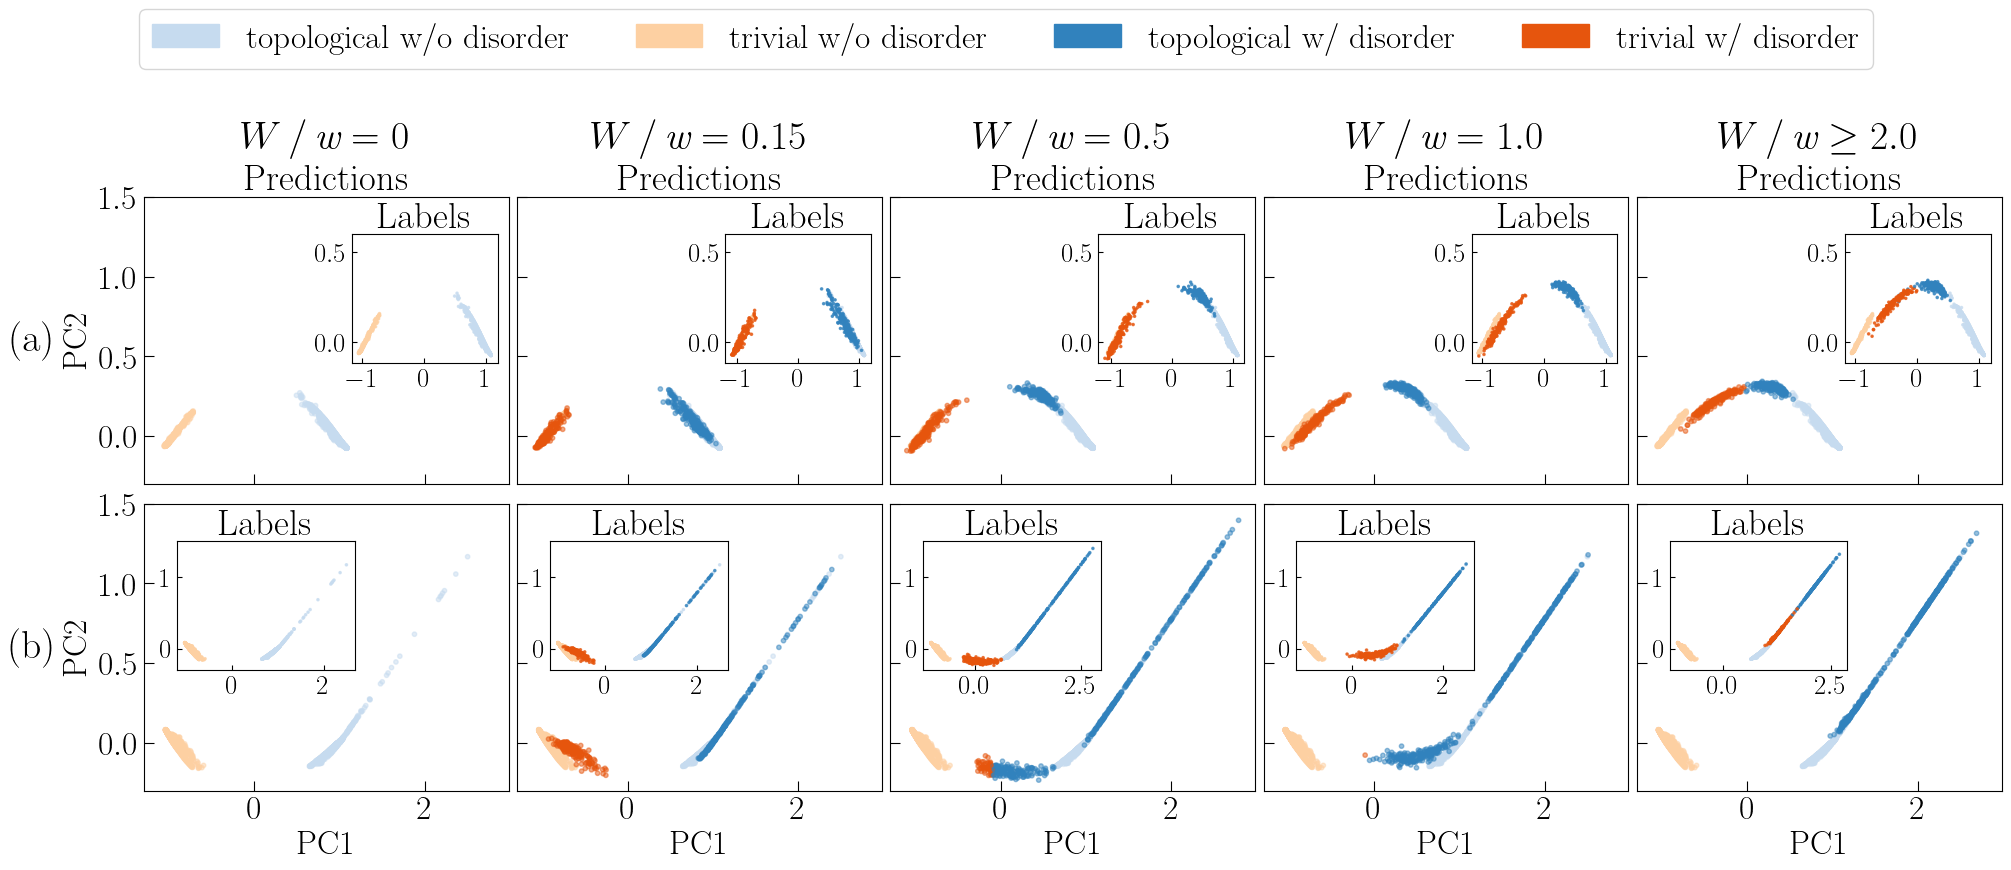

In [42]:
recreate_fig_4(models_root, plots_save_path)

## Recreation of Figs. 12, 13

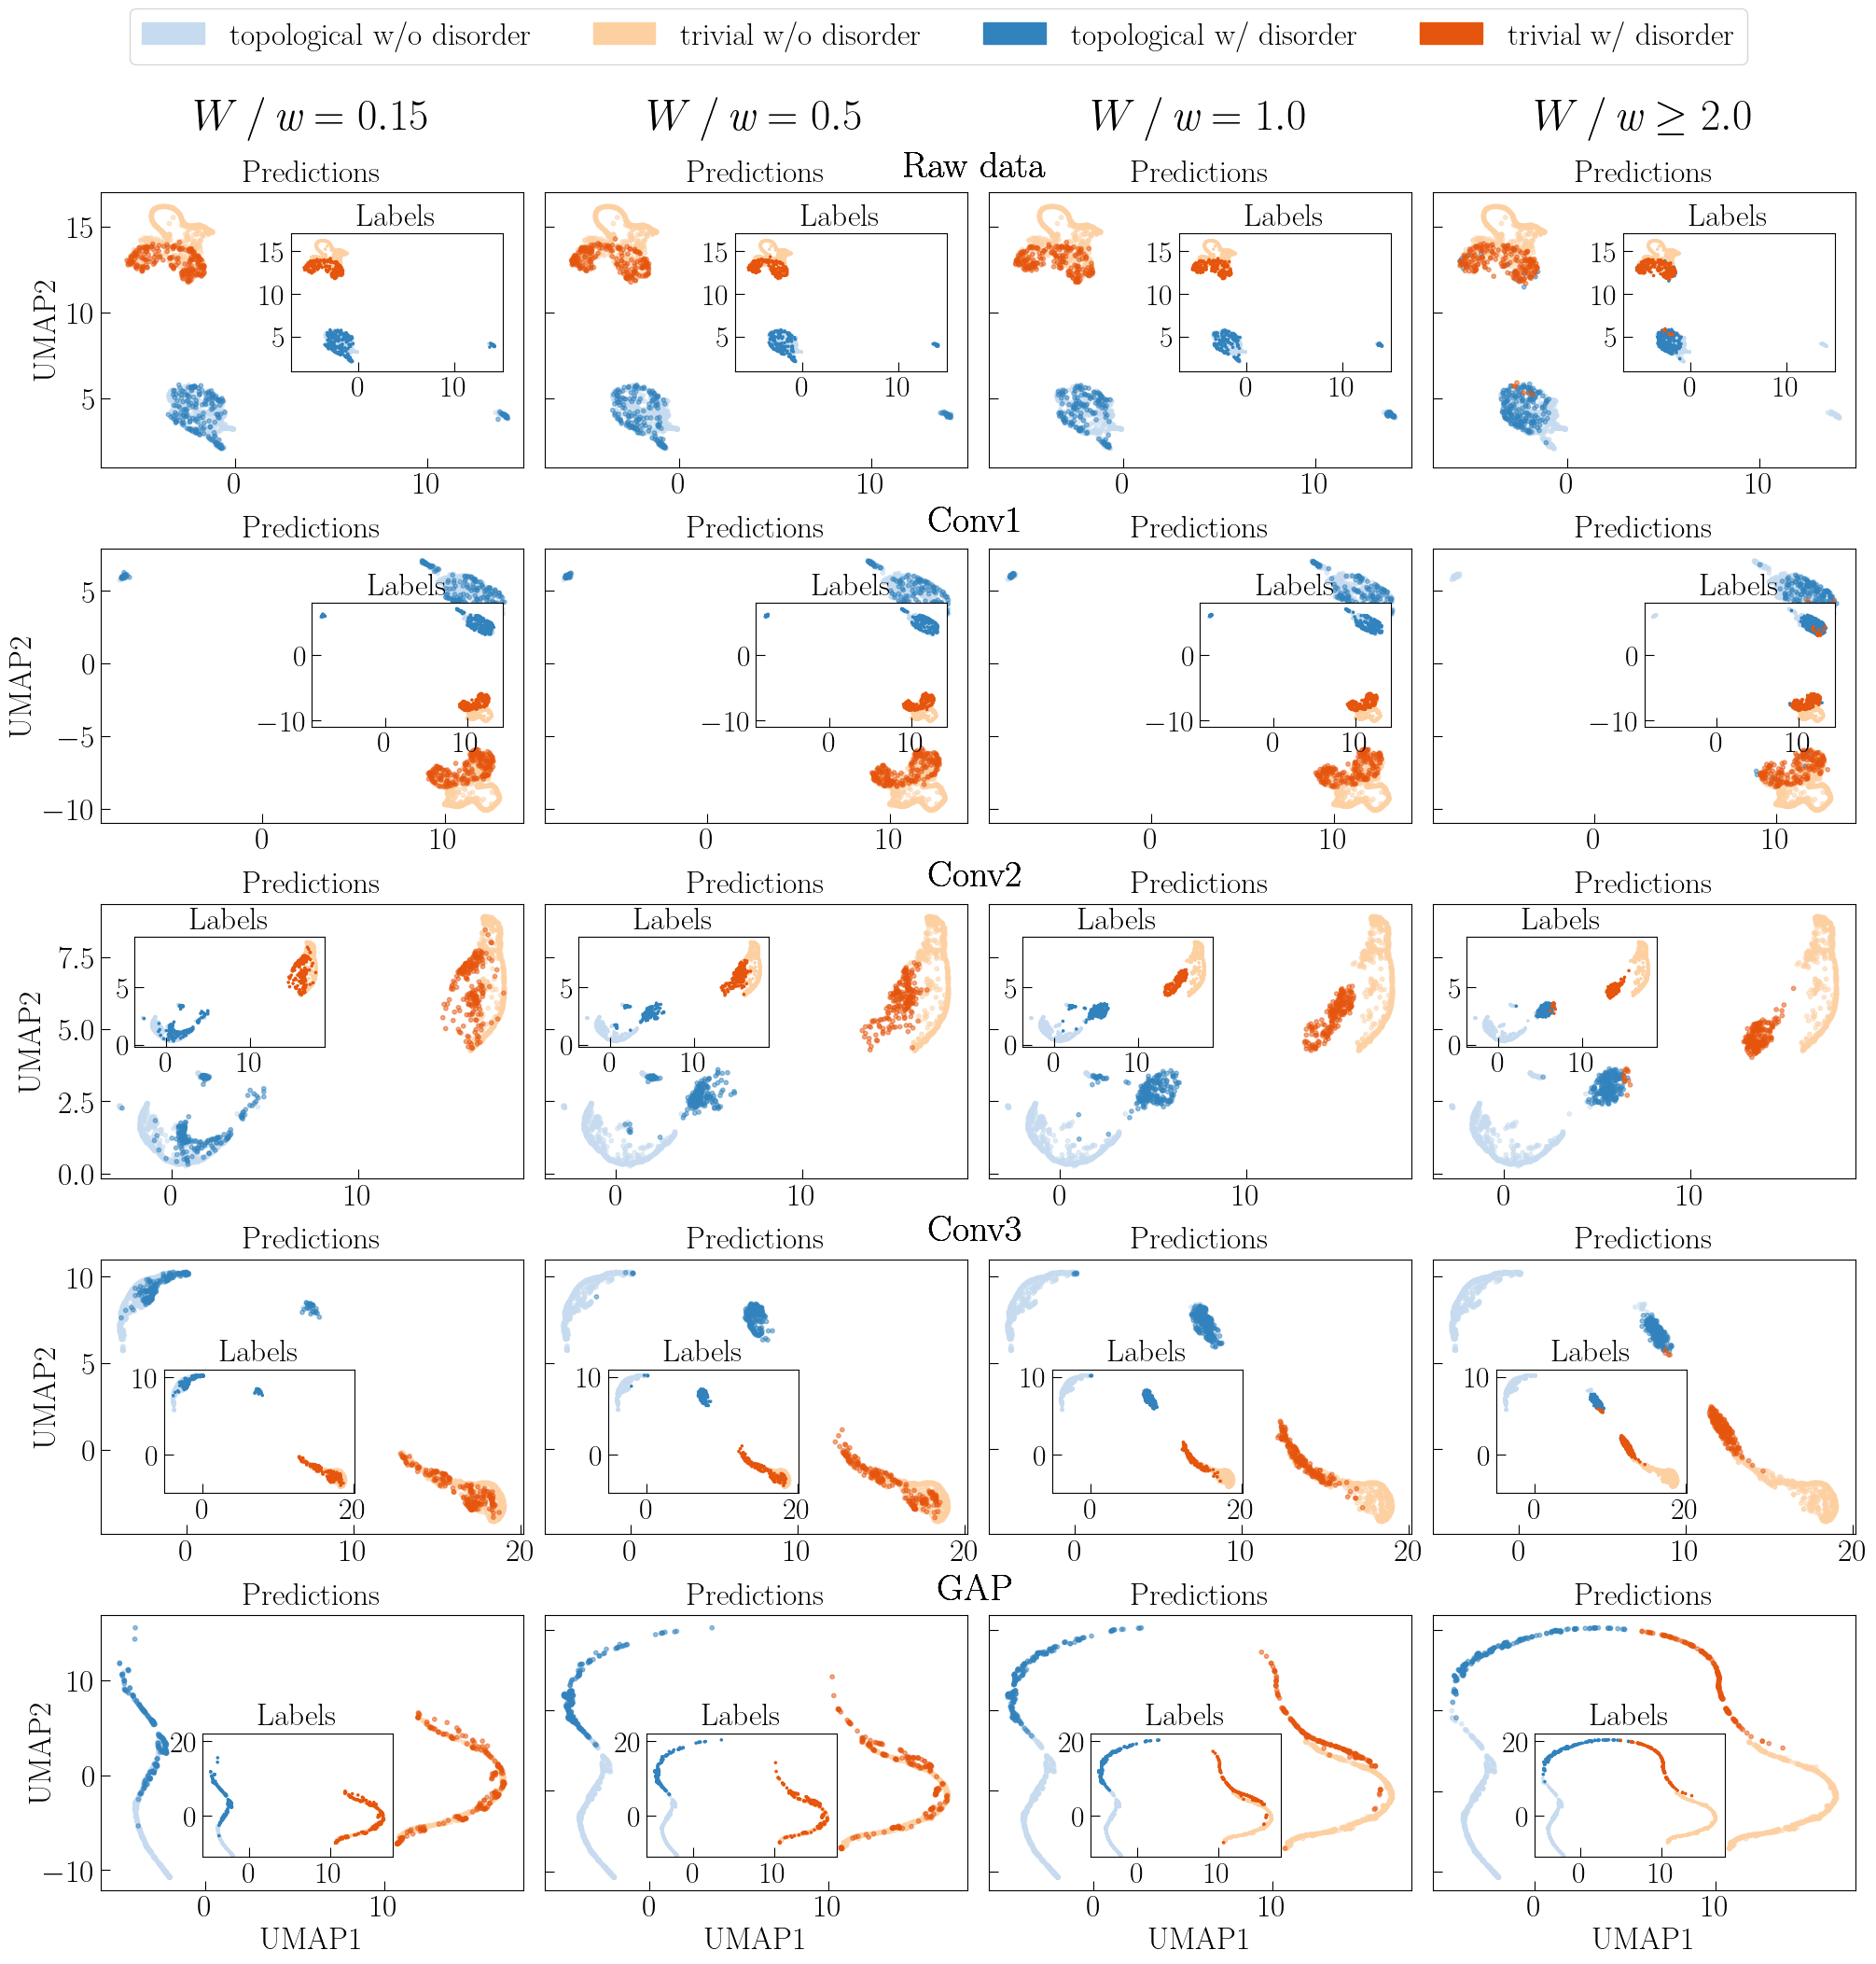

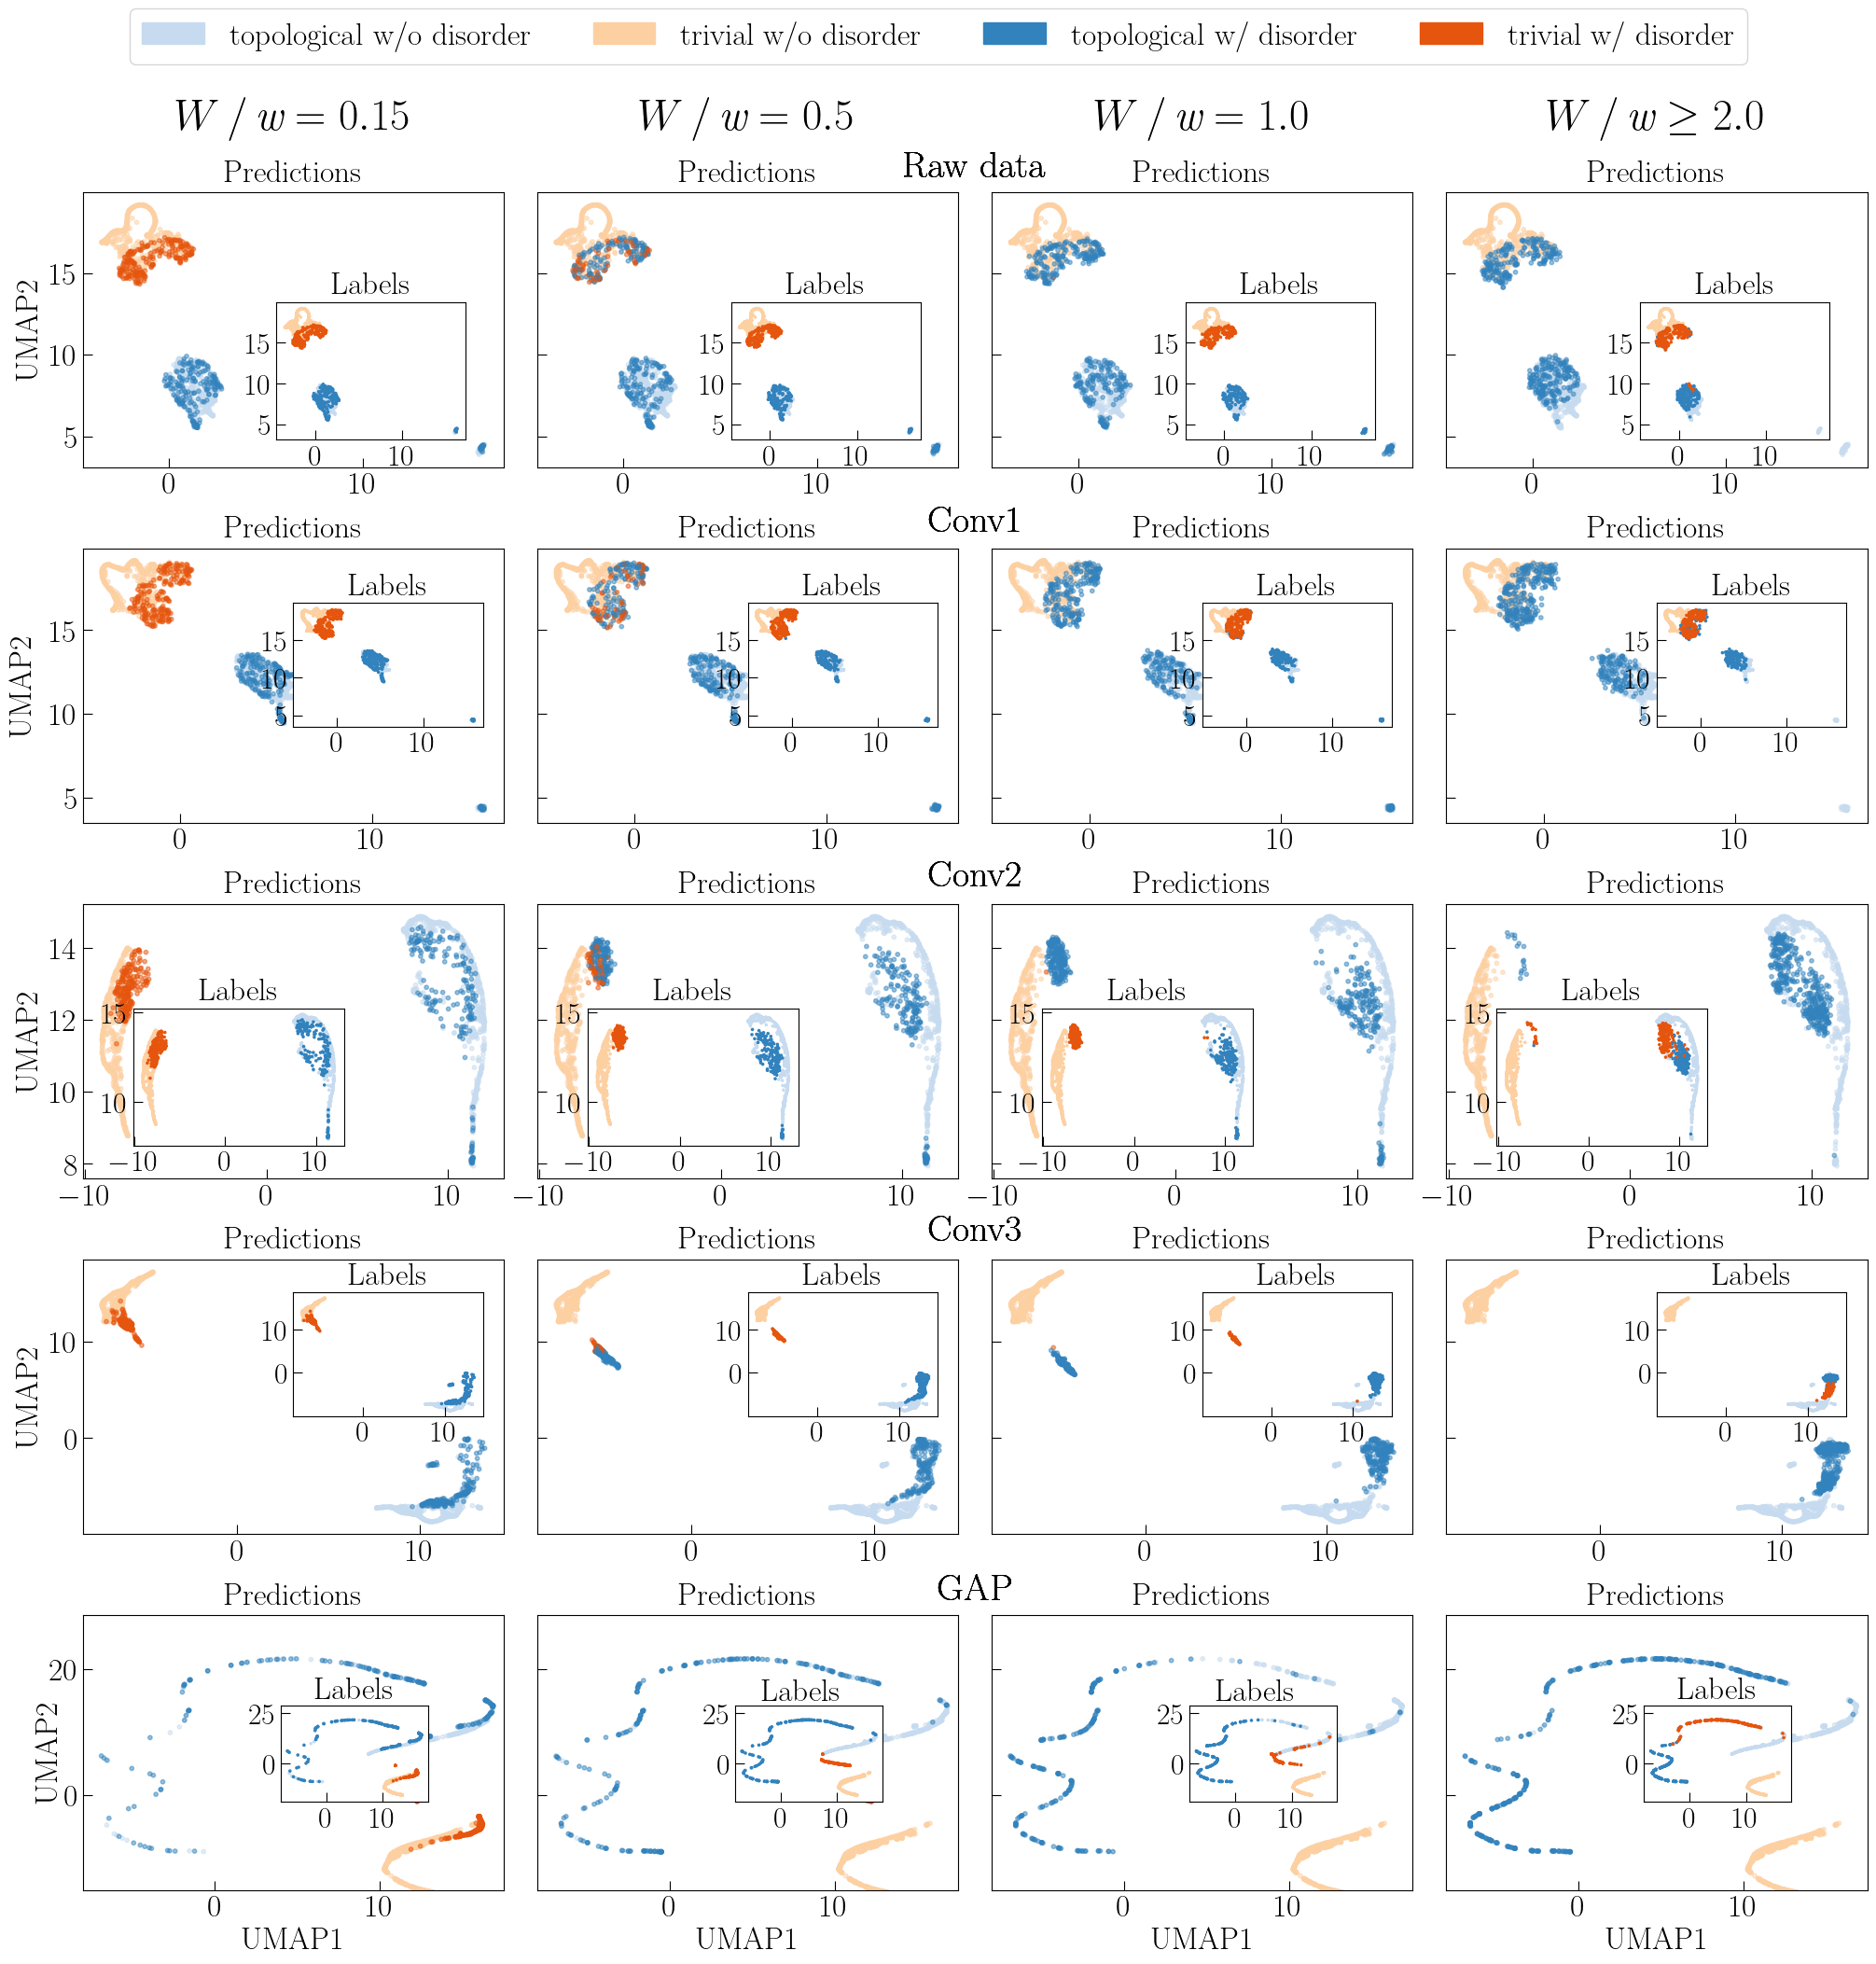

In [43]:
recreate_figs_12_13(models_root, plots_save_path)